In [0]:
from google.colab import drive
drive.mount('/content/drive',force_remount=True)

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
cd /content/drive/My Drive/ML Projects/Emotion Recogition/code/python_files

/content/drive/My Drive/ML Projects/Emotion Recogition/code/python_files


In [0]:
import numpy as np
import os
import sys
import pandas as pd

import wave
from imblearn.over_sampling import SMOTE

import keras
from keras.models import Sequential, Model
from keras.layers.core import Dense, Activation
from keras.layers import LSTM, Input, Flatten,Dropout,GlobalAveragePooling2D,MaxPooling2D,GlobalMaxPooling2D,GlobalAveragePooling1D
from keras.layers.convolutional import Conv2D,Conv1D
from keras.models import load_model
from keras.preprocessing.sequence import pad_sequences
from keras.preprocessing import sequence
from scipy import signal
import matplotlib.pyplot as plt
from helper import *
from features import *
import Metrices as metric
from sklearn.preprocessing import LabelEncoder
from keras.layers import BatchNormalization, Activation,MaxPooling2D,Masking
from sklearn.preprocessing import scale
from sklearn.utils import class_weight
from sklearn.utils.class_weight import compute_class_weight
from keras.callbacks import EarlyStopping
from sklearn import preprocessing



/usr/local/lib/python3.6/dist-packages/sklearn/externals/six.py:31: DeprecationWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", DeprecationWarning)
Using TensorFlow backend.


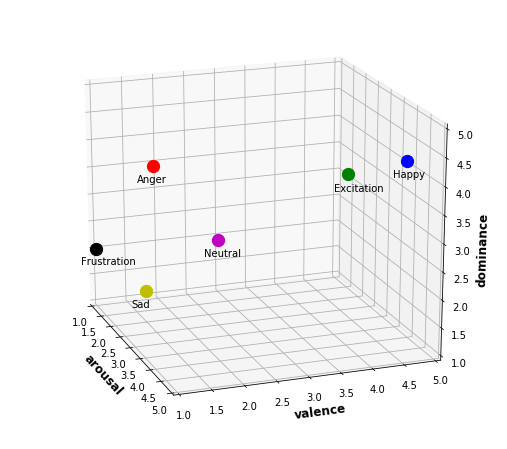

In [0]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.ticker import LinearLocator, FormatStrFormatter
from matplotlib import cm
from matplotlib import gridspec
import numpy as np

def plot_error_surface(arousal, valence, dominance, types):
    
    # plot
    fig = plt.figure(figsize=(14,8))
    gs = gridspec.GridSpec(2, 3, wspace=0.4, hspace=0.3) 
    ax = fig.add_subplot(gs[0:2, 0:2], projection='3d')
    ax.view_init(20, azim = -20)
    #ax.scatter(arousal, valence, dominance, c = 'r', marker = 'o')
    #ax.text(arousal+0.3, valence+0.3, dominance+0.3, type, fontsize=9)
    color = ['r', 'b', 'g', 'k','m','y']
    for i,type in enumerate(types):
        x = arousal[i]
        y = valence[i]
        z = dominance[i]
        ax.scatter(x, y, z, c = color[i], marker = 'o', s = 150)
        ax.text(x+0.2, y-0.3, z-0.2, type, fontsize=10)
    
    # Customize the z axis.
    ax.set_xlim(1, 5)
    #ax.xaxis.set_major_locator(LinearLocator(5))
    #ax.xaxis.set_major_formatter(FormatStrFormatter('%.02f'))
    ax.set_ylim(1, 5)
    #ax.yaxis.set_major_locator(LinearLocator(5))
    #ax.yaxis.set_major_formatter(FormatStrFormatter('%.02f'))
    ax.set_zlim(1, 5)
    #ax.zaxis.set_major_locator(LinearLocator(5))
    #ax.zaxis.set_major_formatter(FormatStrFormatter('%.02f'))
    
    # Set labels
    ax.set_xlabel(r'arousal',size=12,fontweight='bold')
    ax.set_ylabel(r'valence',size=12,fontweight='bold')
    ax.set_zlabel(r'dominance',size=12,fontweight='bold')
    
    plt.show()
    fig.savefig('Error_Surface.pdf',bbox_inches='tight')

arousal = [4,5,4,1,2.5,2]
valence = [1,4.5,4,1,2.5,1.5]
dominance = [4.5,4.5,4,2,2.5,1.5]
types = ['Anger', 'Happy', 'Excitation', 'Frustration','Neutral', 'Sad']
plot_error_surface(arousal, valence, dominance, types)


In [0]:

code_path = os.path.dirname(os.path.realpath(os.getcwd()))
emotions_used = np.array(['ang', 'exc','neu','sad','hap'])
data_path = code_path + "/../data/sessions/"
sessions = ['Session1', 'Session2', 'Session3', 'Session4', 'Session5']
framerate = 16000

In [0]:
import pickle
with open(code_path + '/../data/'+'data_collected.pickle', 'rb') as handle:
    data2 = pickle.load(handle)

In [0]:
data2[700]

{'a': 3.5,
 'd': 4.0,
 'emo_evo': [['ang'], ['fru'], ['fru'], ['fru', 'sur']],
 'emotion': 'fru',
 'id': 'Ses01M_impro01_M017',
 'signal': array([ 172,  208,  223, ..., -134,  -98, -125], dtype=int16),
 'v': 2.5}

In [0]:
!pip install python_speech_features  

  Stored in directory: /root/.cache/pip/wheels/3c/42/7c/f60e9d1b40015cd69b213ad90f7c18a9264cd745b9888134be
Successfully built python-speech-features


In [0]:
from python_speech_features import mfcc
from python_speech_features import logfbank
from sklearn.preprocessing import scale
import scipy.io.wavfile as wav

In [0]:
def pad_sequence_into_array(Xs, maxlen,value=0.):
    
    Nsamples = len(Xs)

    Xout = np.ones(shape=[Nsamples, maxlen] + list(Xs[0].shape[1:]), dtype=Xs[0].dtype) * np.asarray(value, dtype=Xs[0].dtype)
    for i in range(Nsamples):
        x = Xs[i]
        trunc = x[:maxlen]
        Xout[i, :len(trunc)] = trunc
        
    return Xout


In [0]:
X1_train = []
X1_test = []
Y_train = []
Y_test = []
fs = 16e3
for ses_mod in data2:
    #if 'script' in ses_mod['id'] and ses_mod['emotion'] in emotions_used:
    if  ses_mod['emotion'] in emotions_used:
        
        #f, t, Sxx = signal.spectrogram(ses_mod['signal'], fs, nperseg=400,noverlap=200)
        #Sxx= pad_sequence_into_array(Sxx, maxlen=300,value=0)
        #Sxx = calculate_features(ses_mod['signal'], framerate, None)
        fbank_feat = logfbank(ses_mod['signal'],nfilt=40)
        Sxx = np.transpose(fbank_feat)
        Sxx = pad_sequence_into_array(Sxx,maxlen=600,value=0)
        Sxx = np.transpose(Sxx)
        Sxx = scale(Sxx)
        Sxx = np.transpose(Sxx)
        
        temp = [0]*10
        temp[0]=ses_mod['emotion']
        
        if ses_mod['emotion']=='hap':
            temp[0]='exc'
        if 1 <= ses_mod['a'] <=2:
          temp[1]=1
        elif 2 < ses_mod['a'] <=3.5:
          temp[2]=1
        else:
          temp[3]=1
          
        if 1 <= ses_mod['v'] <=2:
          temp[4]=1
        elif 2 < ses_mod['v'] <=3.5:
          temp[5]=1
        else:
          temp[6]=1
          
        if 1 <= ses_mod['d'] <=2:
          temp[7]=1
        elif 2 < ses_mod['d'] <=3.5:
          temp[8]=1
        else:
          temp[9]=1
        
        if ses_mod['id'][:5]=="Ses05":
           
            X1_test.append(Sxx)
            Y_test.append(temp)
        else:
            
            X1_train.append(Sxx)
            Y_train.append(temp)
        


X1_test = np.asarray(X1_test)
X1_train = np.asarray(X1_train)
print(X1_train.shape)
print(X1_test.shape)

(4290, 40, 600)
(1241, 40, 600)


In [0]:
Y_train = np.array(Y_train)
Y_test = np.array(Y_test)

In [0]:
Y_train1 =Y_train[:,1:10]
Y_test1 =Y_test[:,1:10]
print(Y_train1[0])



['0' '1' '0' '0' '1' '0' '0' '1' '0']


In [0]:
from sklearn import preprocessing
le = preprocessing.LabelEncoder()
Y_train[:,0]=le.fit_transform(Y_train[:,0])
Y_test[:,0]=le.transform(Y_test[:,0])

In [0]:
Y_train[0]

array(['2', '0', '1', '0', '0', '1', '0', '0', '1', '0'], dtype='<U3')

In [0]:
from sklearn.preprocessing import OneHotEncoder
enc = OneHotEncoder()
y_train = enc.fit_transform(Y_train[:,0:1]).toarray()
y_test = enc.transform(Y_test[:,0:1]).toarray()

/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/_encoders.py:415: FutureWarning: The handling of integer data will change in version 0.22. Currently, the categories are determined based on the range [0, max(values)], while in the future they will be determined based on the unique values.
If you want the future behaviour and silence this warning, you can specify "categories='auto'".
In case you used a LabelEncoder before this OneHotEncoder to convert the categories to integers, then you can now use the OneHotEncoder directly.
  warnings.warn(msg, FutureWarning)


In [0]:
Y_train = np.delete(Y_train, 0, 1)
Y_test = np.delete(Y_test, 0, 1)

In [0]:
y_train = np.concatenate((y_train,Y_train),axis=1)
y_test = np.concatenate((y_test,Y_test),axis=1)


In [0]:
y_train = y_train.astype(float)
y_test = y_test.astype(float)
y_train = y_train.astype(int)
y_test = y_test.astype(int)

In [0]:
print(y_train[0].shape)

(13,)


In [0]:
X_train = X1_train.reshape(-1,40,600,1)
X_test = X1_test.reshape(-1,40,600,1)

In [0]:
X_train = X1_train.reshape(-1,201,300,1)
X_test = X1_test.reshape(-1,201,300,1)


In [0]:
del X1_train, X1_test

In [0]:
import keras.backend as K

def multitask_loss(y_true, y_pred):
    # Avoid divide by 0
    y_pred = K.clip(y_pred, K.epsilon(), 1 - K.epsilon())
    # Multi-task loss
    return K.mean(K.sum(- y_true * K.log(y_pred) - (1 - y_true) * K.log(1 - y_pred), axis=1))

In [0]:
def make_model():
    in_layer = Input(shape=(40, 600,1))
    #x = Masking(mask_value=0)(in_layer)
    x = Conv2D(32,(5,5),activation = 'elu')(in_layer)
    #x = MaxPooling2D(2,2)(x)
    x = Dropout(0.5)(x)
    x = Conv2D(64,(5,5),activation ='elu')(x) 
    #x = MaxPooling2D(2,2)(x)
    x = Dropout(0.5)(x)
    x = Conv2D(64,(5,5), activation ='elu')(x)
    #x = MaxPooling2D(2,2)(x)
    x = Dropout(0.5)(x)
    x = Conv2D(128, (5,5), activation ='elu')(x)
    #x = MaxPooling2D(2,2)(x)
    x = GlobalAveragePooling2D()(x)                     
    x = Dense(64,activation='elu')(x)
    x = Dropout(0.5)(x)
    output_layer = Dense(13, activation = "sigmoid")(x) # sigmoid output
    model = Model(inputs = in_layer, outputs=output_layer)
    return model

In [0]:
model  =  make_model()
print(model.summary())
model.compile(optimizer = "adam", 
              loss ='binary_crossentropy' ,
              metrics=["accuracy"])
#early_stopping_monitor = EarlyStopping( monitor='val_loss',patience=10,verbose=1)
m_check = keras.callbacks.ModelCheckpoint(filepath = './cnn_spectrogram_multilabel_all5.h5',
                                          monitor='val_loss',
                                          save_best_only=True,
                                          mode='min',
                                          verbose=1 )
hist = model.fit(X_train, y_train, 
                 batch_size=32, validation_data=(X_test,y_test),
                 epochs=100,
                 verbose=1,
                 shuffle = True,
                 callbacks=[m_check] 
                )

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 40, 600, 1)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 36, 596, 32)       832       
_________________________________________________________________
dropout_5 (Dropout)          (None, 36, 596, 32)       0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 32, 592, 64)       51264     
_________________________________________________________________
dropout_6 (Dropout)          (None, 32, 592, 64)       0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 28, 588, 64)       102464    
_________________________________________________________________
dropout_7 (Dropout)          (None, 28, 588, 64)       0         
__________

In [0]:
y_train1 = y_train[:,0:4]

In [0]:
y_test1 = y_test[:,0:4]

In [0]:
y_train2 = np.argmax(y_train1,axis=1)

In [0]:
y_test2 = np.argmax(y_test1,axis=1)

In [0]:
y_test2

array([2, 2, 0, ..., 0, 0, 0])

In [0]:
best_model = load_model('./cnn_spectrogram_multilabel_all5.h5')
print(best_model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 40, 600, 1)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 36, 596, 32)       832       
_________________________________________________________________
dropout_5 (Dropout)          (None, 36, 596, 32)       0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 32, 592, 64)       51264     
_________________________________________________________________
dropout_6 (Dropout)          (None, 32, 592, 64)       0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 28, 588, 64)       102464    
_________________________________________________________________
dropout_7 (Dropout)          (None, 28, 588, 64)       0         
__________

In [0]:
output_train = best_model.predict(X_train)
output_test =  best_model.predict(X_test)

In [0]:
output_train = best_model.predict(X_train)
output_test =  best_model.predict(X_test)

from sklearn.svm import SVC
tr_pred, ts_pred = [], []
for cols in range(13):
    clf = SVC(gamma =.25, C= 1)
    clf.fit(output_train[:,cols:cols+1], y_train[:,cols])
    preds = clf.predict(output_train[:,cols:cols+1])
    tr_pred.append(list(preds))
    preds = clf.predict(output_test[:,cols:cols+1])
    ts_pred.append(list(preds))

tr_pred = np.array(tr_pred).T
ts_pred = np.array(ts_pred).T

print('Accuracy: {0}'.format(metric.accuracy(y_test, ts_pred)*100))
print('Recall: {0}'.format(metric.recall(y_test, ts_pred)*100))
print('Precision: {0}'.format(metric.precision(y_test, ts_pred)*100))
print('F1-score: {0}'.format(metric.f_score(y_test, ts_pred)*100))


Accuracy: 55.053646234077114
Recall: 64.00359066427289
Precision: 67.50448833034112
F1-score: 65.28739562850873


In [0]:
print(tr_pred[1680])
print(output_train[1680])
print(y_train[1680])

[0 0 0 0 0 1 0 0 0 0 0 1 0]
[0.27179372 0.15025824 0.3061493  0.03955367 0.02591535 0.6875979
 0.23415396 0.39909416 0.37785628 0.17660522 0.03297442 0.54240113
 0.4038895 ]
[0 1 0 0 0 1 0 0 1 0 0 0 1]


In [0]:
output_train[0]

array([0.03643265, 0.09494522, 0.44045165, 0.4536484 , 0.44721463,
       0.62465864, 0.03272954, 0.18809709, 0.6525277 , 0.13352674,
       0.29612148, 0.75245786, 0.05934328], dtype=float32)

In [0]:
# Based on discrete labels

from keras.models import Sequential
from keras.layers import Dense, Activation

model = Sequential()
model.add(Dense(64, activation = 'elu', input_dim=128))
#model.add(Dropout(0.1))
model.add(Dense(128, activation = 'elu'))
#model.add(Dropout(0.2))

model.add(Dense(4, activation = 'softmax'))

model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])
m_check = keras.callbacks.ModelCheckpoint(filepath = './cnn_dis_model_multilabelhap_logmail.h5', monitor='val_acc', save_best_only=True, mode='max', verbose=1 )
hist = model.fit(output_train, y_train1, 
                 batch_size=32, 
                 validation_data=(output_test, y_test1),
                 nb_epoch=100, verbose=1,
                 shuffle = True,
                 callbacks=[m_check] 
                )

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:22: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.


Train on 2091 samples, validate on 497 samples
Epoch 1/100
2091/2091 [==============================] - 1s 403us/step - loss: 1.1973 - acc: 0.4500 - val_loss: 1.0935 - val_acc: 0.5231

Epoch 00001: val_acc improved from -inf to 0.52314, saving model to ./cnn_dis_model_multilabelhap_logmail.h5
Epoch 2/100
2091/2091 [==============================] - 0s 114us/step - loss: 1.1568 - acc: 0.4754 - val_loss: 1.0847 - val_acc: 0.5835

Epoch 00002: val_acc improved from 0.52314 to 0.58350, saving model to ./cnn_dis_model_multilabelhap_logmail.h5
Epoch 3/100
2091/2091 [==============================] - 0s 113us/step - loss: 1.1520 - acc: 0.4802 - val_loss: 1.0411 - val_acc: 0.5734

Epoch 00003: val_acc did not improve from 0.58350
Epoch 4/100
2091/2091 [==============================] - 0s 106us/step - loss: 1.1475 - acc: 0.4711 - val_loss: 1.0731 - val_acc: 0.5332

Epoch 00004: val_acc did not improve from 0.58350
Epoch 5/100
2091/2091 [==============================] - 0s 124us/step - loss: 1

In [0]:
model = load_model('./cnn_dis_model_multilabelhap_logmail.h5')

In [0]:
from sklearn.metrics import classification_report, accuracy_score
y_pred = model.predict(output_test)

for i in range(len(y_pred)):
  for j in range(len(y_pred[i])) :
    if y_pred[i][j]==max(y_pred[i]) :
      y_pred[i][j] = 1
    else:
      y_pred[i][j]=0
      
print(classification_report(y_test1,y_pred))

              precision    recall  f1-score   support

           0       0.73      0.84      0.78       243
           1       0.45      0.27      0.34       108
           2       0.40      0.55      0.46        84
           3       0.31      0.18      0.22        62

   micro avg       0.59      0.59      0.59       497
   macro avg       0.47      0.46      0.45       497
weighted avg       0.56      0.59      0.56       497
 samples avg       0.59      0.59      0.59       497



In [0]:
from sklearn.metrics import confusion_matrix
confusion_matrix(
    y_test1.argmax(axis=1), y_pred.argmax(axis=1))

array([[205,  10,  26,   2],
       [ 53,  29,  13,  13],
       [ 20,   8,  46,  10],
       [  3,  18,  30,  11]])

In [0]:
output_train = best_model.predict(X_train)
output_test =  best_model.predict(X_test)

In [0]:
from keras.models import Model

layer_name = 'global_average_pooling2d_2'
intermediate_layer_model = Model(inputs=best_model.input,
                                 outputs=best_model.get_layer(layer_name).output)
output_train = intermediate_layer_model.predict(X_train)
output_test =  intermediate_layer_model.predict(X_test)

In [0]:
import tflearn
import pickle
from models.elm.elm import ELMClassifier, GenELMClassifier
from models.elm.random_layer import RandomLayer, MLPRandomLayer, RBFRandomLayer, GRBFRandomLayer  
rbf_width = 0.1
"""Extreme Learning Machine"""
rhl = RBFRandomLayer(n_hidden=50, rbf_width=0.01)
elmr = GenELMClassifier(hidden_layer=rhl)
elmr.fit(output_train , y_train1)
y_pred=elmr.predict(output_test)
print(y_pred)
test_weighted_accuracy=elmr.score(output_test, y_test1)
print(test_weighted_accuracy)

[[0 0 0 0]
 [0 0 0 0]
 [1 0 0 0]
 ...
 [1 0 0 0]
 [1 0 0 0]
 [1 0 0 0]]
0.4391619661563255


In [0]:
# Based on continuous labels

from keras.models import Sequential
from keras.layers import Dense, Activation

model = Sequential()
#keras.initializers.lecun_uniform(seed=None)
model.add(Dense(20, activation = 'elu', input_dim=13))
model.add(Dense(20, activation = 'elu'))
#model.add(Dense(256, activation = 'selu'))
model.add(Dense(4, activation = 'softmax'))

model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])
Y_label = ( [np.where(r==1)[0][0] for r in y_train1] )
early_stopping_monitor = EarlyStopping( monitor='val_loss',patience=20,verbose=1)
m_check = keras.callbacks.ModelCheckpoint(filepath = './cnn_model_multilabeltry1.h5', monitor='val_acc', save_best_only=True, mode='max', verbose=1 )
hist = model.fit(output_train, y_train1, 
                 batch_size=32, 
                 validation_data=(output_test, y_test1),
                 nb_epoch=100, verbose=1,
                 shuffle = True,
                 callbacks=[m_check,early_stopping_monitor],
class_weight = class_weight.compute_class_weight("balanced", np.unique(Y_label), Y_label))
                

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:24: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.


Train on 4290 samples, validate on 1241 samples
Epoch 1/100
4290/4290 [==============================] - 3s 726us/step - loss: 1.1448 - acc: 0.5100 - val_loss: 1.0470 - val_acc: 0.5520

Epoch 00001: val_acc improved from -inf to 0.55197, saving model to ./cnn_model_multilabeltry1.h5
Epoch 2/100
4290/4290 [==============================] - 1s 130us/step - loss: 0.9309 - acc: 0.6152 - val_loss: 1.0254 - val_acc: 0.5681

Epoch 00002: val_acc improved from 0.55197 to 0.56809, saving model to ./cnn_model_multilabeltry1.h5
Epoch 3/100
4290/4290 [==============================] - 1s 133us/step - loss: 0.9053 - acc: 0.6268 - val_loss: 1.0261 - val_acc: 0.5592

Epoch 00003: val_acc did not improve from 0.56809
Epoch 4/100
4290/4290 [==============================] - 1s 127us/step - loss: 0.8913 - acc: 0.6329 - val_loss: 1.0257 - val_acc: 0.5592

Epoch 00004: val_acc did not improve from 0.56809
Epoch 5/100
4290/4290 [==============================] - 1s 134us/step - loss: 0.8885 - acc: 0.6294 -

In [0]:
best_model = load_model('./cnn_model_multilabeltry.h5')

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use tf.cast instead.


In [0]:
from sklearn.metrics import classification_report, accuracy_score
y_pred = best_model.predict(output_test)

for i in range(len(y_pred)):
  for j in range(len(y_pred[i])) :
    if y_pred[i][j]==max(y_pred[i]) :
      y_pred[i][j] = 1
    else:
      y_pred[i][j]=0
      
print(classification_report(y_test1,y_pred))

NameError: ignored

In [0]:
from sklearn.metrics import confusion_matrix
confusion_matrix(np.argmax(y_test1,axis=1), np.argmax(y_pred,axis=1))

array([[ 17,   4,   8,   2],
       [  5,  83,  81,   5],
       [  4,  24, 224,  35],
       [  0,   9,  30,  94]])

In [0]:
from mlxtend.evaluate import confusion_matrix
m = confusion_matrix(y_target=y_test1, 
                      y_predicted=y_pred, 
                      binary=False)
print(m)

ValueError: ignored

In [0]:
print(output_train.shape)

(2034, 13)


In [0]:
y_train1

array([[0, 0, 1, 0],
       [0, 0, 1, 0],
       [0, 0, 1, 0],
       ...,
       [0, 0, 1, 0],
       [0, 0, 1, 0],
       [0, 0, 1, 0]])

In [0]:
labelencoder = LabelEncoder()
y_train = labelencoder.fit_transform(y_train1)
y_test = labelencoder.transform(y_test1)

ValueError: ignored

In [0]:
output_train = best_model.predict(X_train)
output_test =  best_model.predict(X_test)

ValueError: ignored

In [0]:
# Fitting Random Forest Classification to the Training set
from sklearn.ensemble import RandomForestClassifier
classifier = RandomForestClassifier(n_estimators = 100, criterion = 'entropy', random_state = 0,n_jobs=-1)
classifier.fit(output_train, y_train2)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='entropy',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=-1,
            oob_score=False, random_state=0, verbose=0, warm_start=False)

In [0]:
y_pred = classifier.predict(output_test)

In [0]:
print(classification_report(y_test2,y_pred))

              precision    recall  f1-score   support

           0       0.32      0.26      0.29        31
           1       0.61      0.38      0.47       174
           2       0.58      0.71      0.64       287
           3       0.58      0.60      0.59       133

   micro avg       0.57      0.57      0.57       625
   macro avg       0.52      0.49      0.50       625
weighted avg       0.58      0.57      0.56       625



In [0]:
from sklearn.svm import SVC
classifier = SVC(kernel = 'rbf', random_state = 0)
classifier.fit(output_train, y_train2)

/usr/local/lib/python3.6/dist-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
  kernel='rbf', max_iter=-1, probability=False, random_state=0,
  shrinking=True, tol=0.001, verbose=False)

In [0]:
y_pred = classifier.predict(output_test)

In [0]:
print(classification_report(y_test2,y_pred))

              precision    recall  f1-score   support

           0       0.80      0.13      0.22        31
           1       0.64      0.34      0.45       174
           2       0.58      0.82      0.68       287
           3       0.69      0.62      0.65       133

   micro avg       0.61      0.61      0.61       625
   macro avg       0.68      0.48      0.50       625
weighted avg       0.63      0.61      0.59       625



In [0]:
from xgboost import XGBClassifier

In [0]:
xg_model1 = XGBClassifier(n_estimators=300,learning_rate=0.2,max_depth=100,objective = 'multi:softmax',
                       num_class=4,n_jobs=-1)

In [0]:
xg_model1.fit(output_train,y_train2)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.2, max_delta_step=0,
       max_depth=100, min_child_weight=1, missing=None, n_estimators=300,
       n_jobs=-1, nthread=None, num_class=4, objective='multi:softprob',
       random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
       seed=None, silent=True, subsample=1)

In [0]:
y_pred = xg_model1.predict(output_test)

In [0]:
print(classification_report(y_test2,y_pred))

              precision    recall  f1-score   support

           0       0.31      0.35      0.33        31
           1       0.59      0.41      0.48       174
           2       0.61      0.69      0.65       287
           3       0.58      0.63      0.60       133

   micro avg       0.58      0.58      0.58       625
   macro avg       0.52      0.52      0.52       625
weighted avg       0.59      0.58      0.58       625



In [0]:
import numpy
x=numpy.full((100, 256),
1/256, dtype=numpy.float32)
print(x.shape)

(100, 256)
